# SNE总结

&emsp;&emsp;SNE(stochastic neighbor embedding，随机邻域嵌入)是一种挖掘高维数据的非线性降维算法，非常适用于高维数据降维到2维或者3维，并进行可视化。在了解SNE的思想后，我们先补充一些数学知识，然后从SNE的原理，优化（对称SNE，t-SNE），python实现以及和PCA的对比等方面对SNE进行总结。

## SNE的思想
&emsp;&emsp;在高维空间相似的数据点，映射到低维空间距离也是相似的。常规的做法是用欧式距离表示这种相似性，但是SNE把这种距离关系转换为一种条件概率来表示相似性。<br>
&emsp;&emsp;SNE是通过仿射(affinitie)变换将数据点映射到概率分布上，主要包括两个步骤：<br>
&emsp;&emsp;&emsp;&emsp;SNE构建一个高维对象之间的概率分布，使得相似的对象有更高的概率被选择，而不相似的对象有较低的概率被选择。<br>
&emsp;&emsp;&emsp;&emsp;SNE在低维空间里在构建这些点的概率分布，使得这两个概率分布之间尽可能的相似。<br>

## 数学基础
### 流形学习
&emsp;&emsp; 我们以一个例子来了解流形学习。地球表面可以看作是一个流形，在流形上计算距离与欧式空间有所区别。例如，计算南极与北极点之间的距离不是从地心穿一个洞计算直线距离，而是沿着地球表面寻找一条最短路径，这样的一条路径称为测地线。如下面三幅图所示：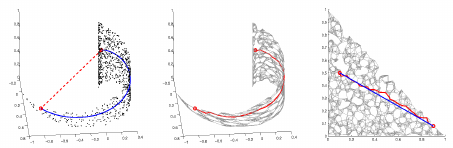
其中第一张图为原始数据点分布，红色虚线是欧式距离，蓝色实线是沿着流形的真实测地线距离。第二张图是在原始数据点的基础上基于欧式距离构造的kNN图（灰色线条，下面还会具体介绍kNN图），红色实线表示kNN图中两点之间的最短路径距离。第三张图是将流形展开后的效果，可以看到，kNN图中的最短路径距离（红色实线）要略长于真实测地线距离（蓝色实线）。在实际应用中，真实测地距离较难获得，一般可以通过构造kNN图，在kNN图中寻找最短路径距离作为真实测地线距离的近似。
### kNN图
&emsp;&emsp; kNN图(k-Nearest Neighbour Graph)实际上是在经典的kNN(k-Nearest Neighbor)算法上增加了一步构图过程。假设空间中有$n$个节点，对节点$v_{i}$，通过某种距离方式（欧式距离，编辑距离等）找出距离它最近的$k$个邻居$v_{1}$，$v_{2}$，...$v_{k}$，然后分别将$v_{i}$与这$k$个邻居连接起来，形成$k$条有向边。对空间中所有顶点均按此方式进行，最后就得到了kNN图。为方便起见，在许多场景中我们往往将kNN图中的有向边视为无向边处理。如下图是一个二维空间中以欧式距离为度量的kNN图。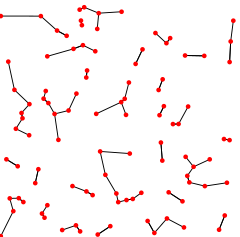
### t分布
&emsp;&emsp; 假设$X$是呈正太分布的独立的随机变量（随机变量的期望值是$\mu$，方差为$\sigma^{2}$但未知）。从正太总体中抽取容量为$N$的随机样本，随机样本均值为$\overline{x}$，随机样本方差为$s^{2}= \frac{1}{N-1}\sum_{i=1}^{N}(x_{i}-\overline{x})^{2}$，随机变量t可表示为$t = \frac{\overline{x} - \mu}{s/\sqrt{N}}$。此时我们称t服从自由度为$N-1$的t分布，即t～t(N-1)
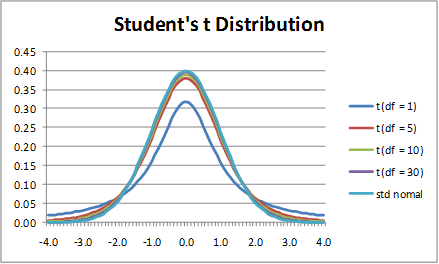
可以看出，$t$分布和正太分布相比要“胖”一些，尤其在尾部两端较为平缓。$t$分布是一种典型的长尾分布。

## SNE原理
&emsp;&emsp;SNE是先将欧几里得距离转换为条件概率来表达点与点之间的相似度。具体来说，给定N个高维数据$x_{1}$,...$x_{N}$,（注意N不是维度）。其中数据点$x_{i}$以条件概率$p_{j|i}$选择$x_{j}$作为它的临近点。考虑以$x_{i}$为中心点的高斯分布，若$x_{j}$越靠近$x_{i}$，则$p_{j|i}$越大。反之，若两者相距较远，则$p_{j|i}$极小。因此我们可以这样定义$p_{j|i}$：

$$p_{j|i}=\frac{exp(-||x_{i}-x_{j}||^{2}/(2\sigma_{i}^{2}))}{\sum_{k\neq i}exp(-||x_{i}-x_{k}||^{2}/(2\sigma_{i}^{2}))}$$

&emsp;&emsp;$\sigma_{i}$表示以$x_{i}$为中心点的高斯分布的方差。不同的$x_{i}$取值不一样。此外设置$p_{x|x}=0$，因为我们只关心不同点对之间的相似度。<br>
&emsp;&emsp;当我们把数据映射到低维空间后，高维数据点之间的相似性也应该在低维空间的数据点上体现出来。这里同样用条件概率的形式描述，假设高维数据点$x_{i}$和$x_{j}$在低维空间的映射点分别为$y_{i}$和$y_{j}$，类似的，在低维空间中的条件概率用$q_{j|i}$表示，且指定高斯分布的方差为$\frac{1}{\sqrt{2}}$。则它们之间的相似度如下：

$$q_{j|i}=\frac{exp(-||y_{i}-y_{j}||^{2})}{\sum_{k\neq i}exp(-||y_{i}-y_{k}||^{2})}$$

&emsp;&emsp;同理，设定$q_{x|x}=0$。若$y_{i}$和$y_{j}$真实反映了高维数据点$x_{i}$和$x_{j}$之间的关系，那么条件概率$p_{j|i}$和$q_{j|i}$应该完全相等。若我们考虑$x_{i}$和其他所有点之间的条件概率，则可以构成一个条件概率分布$P_{i}$，同理，在低维空间存在一个条件概率分布$Q_{i}$，且应该与$P_{i}$一致。（这体现的是对局部特征的保留。）<br>
&emsp;&emsp;我们用经典的KL距离（Kullback-Leibler Divergence）来衡量两个分布之间的相似性，我们的目标就是对所有数据点最小化这个KL距离，目标函数如下：

$$C = \sum_{i}KL(P_{i}||Q_{i}) = \sum_{i}\sum_{j}p_{j|i}log\frac{p_{j|i}}{q_{j|i}}$$

&emsp;&emsp;有了目标函数，我们可以使用梯度下降算法进行训练。<br>

&emsp;&emsp;但是需要注意的是KL散度具有不对称性，最小化代价函数的目的是让$p_{j|i}$和$q_{j|i}$的值尽可能的接近，即低维空间中的点的相似性与高维空间中一致。但在低维空间中不同的距离对应的惩罚权重是不同的。具体来说：距离较远的两个点来表达距离较近的两个点会产生更大的cost，相反，用较近的两个点来表达较远的两个点产生的cost相对较小(注意：类似于回归容易受异常值影响，但效果相反)。即用较小的$q_{j|i} = 0.2$来建模较大的$p_{j|i} = 0.8$，cost = 1.11，如果用较大的$q_{j|i} = 0.8$建模较小的$p_{j|i} = 0.2$，cost = -0.277。也就是说，高维空间中如果两个点距离较近，而映射到低维空间后距离较远，那么将得到一个很高的惩罚，这一项是没有问题的。但是如果高维空间中两个数据点距离较远，而映射到低维空间距离较近，将得到一个很低的惩罚，但是这里理应得到一个很高的惩罚。SNE的这一缺点会造成拥挤问题，同时也反映出其更关注局部结构，而忽略了全局结构。<br>

&emsp;&emsp;这里简要提一下如何选择$\sigma$，首先不同的点具有不同的$\sigma_{i}$，$P_{i}$的熵（entropy）也会随着$\sigma_{i}$的增加而增加。SNE使用困惑度（perplexity）的概念，用二分搜索的方式来寻找一个最佳的$\sigma$，其中困惑度指：

$$Perp(P_{i}) = 2^{H(P_{i})}$$

这里的$H(P_{i})$是$P_{i}$的熵，即：

$$H(P_{i}) = - \sum_{i}p_{j|i}log_{2}p_{j|i}$$

困惑度可以解释为一个点附近的有效近邻个数。SNE对困惑度的调整比较有鲁棒性，通常选择在5-50之间，给定之后，使用二分搜索的方式寻找合适的$\sigma$。<br>

&emsp;&emsp;SNE对$y_{i}$求梯度后的形式如下：
$$\frac{\delta C}{\delta y_{i}} = 2\sum_{j}(p_{j|i}-q_{j|i}+p_{i|j}-q_{i|j})(y_{i}-y_{j})$$

这个梯度还有一定的物理意义，我们可以用分子之间的引力和斥力进行解释。低维空间中点$y_{i}$的位置是由其他所有点对其作用力的合力所决定的。其中某个点$y_{j}$对其作用力是沿着$y_{i}-y_{j}$方向的，具体是引力还是斥力占主导取决于$y_{j}$与$y_{i}$之间的距离。，也就是$(p_{j|i}-q_{j|i}+p_{i|j}-q_{i|j})$这一项。<br>

&emsp;&emsp;在初始化中，可以用较小的$\sigma$下的高斯分布来进行初始化。为了加速优化过程和避免陷入局部最优解，梯度中需要使用一个相对较大的动量（momentum）。即参数更新中除了当前的梯度，还要引入之前的梯度累加的指数衰减项，如下：

$$Y^{(t)} = Y^{(t-1)} + \eta\frac{\delta C}{\delta Y} + \alpha(t)(Y^{(t-1)}-Y^{(t-2)})$$

这里的$Y^{(t)}$表示迭代t次的解，$\eta$表示学习速率，$\alpha(t)$表示迭代t次的动量。此外，在初始优化的阶段，每次迭代中可以引入一些高斯噪声，之后像模拟退火一样逐渐减小该噪声，可以用来避免陷入局部最优解。因此，SNE在选择高斯噪声，以及学习速率，什么时候开始衰减，动量选择等等超参数上，需要跑多次优化才可以。


## SNE优化 — 对称SNE
&emsp;&emsp;在原始的SNE中，$p_{i|j}$和$p_{j|i}$是不相等的，低维空间中$q_{i|j}$和$q_{j|i}$也是不相等的。所以如果能得出一个更加通用的联合概率分布（而不是SNE的条件概率分布）则更加合理，即分别在高维何低维空间构造联合概率分布P和Q，使得对任意的i，j，均有$p_{i|j}=p_{j|i}$，$q_{i|j}=q_{j|i}$。<br>
&emsp;&emsp;在低维空间中，我们可以这样定义$q_{i|j}$：

$$q_{i|j}=\frac{exp(-||y_{i}-y_{j}||^{2})}{\sum_{k\neq l}exp(-||y_{k}-y_{l}||^{2})}$$  

&emsp;&emsp;在高维空间中，我们采用一种更简单直观的方式定义$p_{i|j}$：
$$p_{i|j}=\frac{p_{j|i}+p_{i|j}}{2n}$$
其中n为数据点的总数，这样定义既满足了了对称性，又保证了$x_{i}$的惩罚值不会过小，此时可以利用KL距离写出如下代价函数：

$$C = KL(P||Q) = \sum_{i}\sum_{j}p_{i|j}log\frac{p_{i|j}}{q_{i|j}}$$

梯度变为：
$$\frac{\delta C}{\delta y_{i}} = 4\sum_{j}(p_{i|j}-q_{i|j})(y_{i}-y_{j})$$

这里需要注意： 高维空间中的$p_{i|j}$为什么不能定义为$p_{i|j}=\frac{exp(-||x_{i}-x_{j}||^{2}/(2\sigma_{i}^{2}))}{\sum_{k\neq l}exp(-||x_{k}-x_{l}||^{2}/(2\sigma_{i}^{2}))}$？
&emsp;&emsp;考虑一个离群点$x_{i}$，它与所有节点之间的距离都较大，那么对所有的j，$p_{i|j}$的值均较小，所以无论该离群点在低维空间中的映射点$y_{i}$在什么位置，惩罚值都不会太高，这显然不是我们希望看到的。而如果我们使用$p_{i|j}=\frac{p_{j|i}+p_{i|j}}{2n}$，这样可以保证$\sum_{j}p_{i|j}> \frac{1}{2n}$，使得每个点对于cost都会有一定的贡献，同时也会使得梯度计算变得简单。

## SNE优化 — t-SNE
&emsp;&emsp;在讲t-SNE之前，我们先了解一下拥挤问题。
### 拥挤问题
&emsp;&emsp;将SNE算法用在UPS database的手写数字数据集上（5种数字，01234），效果如下：
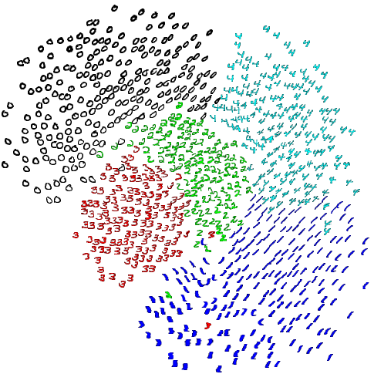
可以看出，SNE的可视化效果还算可以，同一类别的数据点映射到二维空间后基本都能聚集在一起，但是不同簇之间的边界过于模糊。如果不用不同颜色和符号进行标识，根本没办法把边界处的数据点区分开来，这就是拥挤问题。拥挤问题的出现虽然和SNE关注局部结构，忽略全局结构这一特性有一定关系，但是最根本的原因还是高维空间距离分布和低维空间距离分布的差异造成的。比如说，在10维的空间中有11个点之间两两距离相等，在二维空间下酒无法得到可信的映射结果（最多3个点）。通过一个实验进一步说明，假设一个以数据点$x_{i}$为中心，半径为r的m维球（二维空间是圆，三维空间是球），其体积是按照$r^{m}$增长的，假设数据点在m维球中均匀分布，我们来看看其他数据点与$x_{i}$的距离随纬度增大而产生的变化。

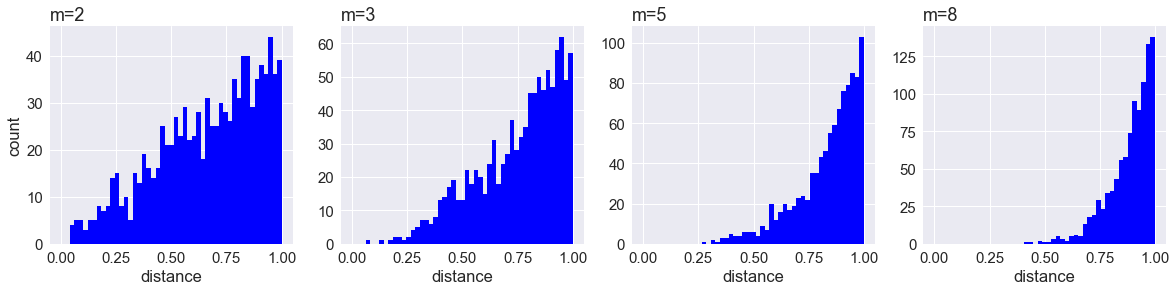

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
%matplotlib inline
npoints = 1000 # 抽取1000个m维球内均匀分布的点
plt.figure(figsize=(20, 4))
for i, m in enumerate((2, 3, 5, 8)):
    # 这里模拟m维球中的均匀分布用到了拒绝采样，即先生成m维立方中的均匀分布，再剔除m维球外部的点
    accepts = []
    while len(accepts) < 1000:
        points = np.random.rand(500, m)
        accepts.extend([d for d in norm(points, axis=1) if d <= 1.0]) # 拒绝采样
    accepts = accepts[:npoints]
    ax = plt.subplot(1, 4, i+1)
    ax.set_xlabel('distance') # x轴表示点到圆心的距离
    if i == 0:
        ax.set_ylabel('count') # y轴表示点的数量
    ax.hist(accepts, bins=np.linspace(0., 1., 50), color='blue')
    ax.set_title('m={0}'.format(str(m)), loc='left')
plt.show()

&emsp;&emsp;从图中可以看到，随着维度的增大，大部分数据点都聚集在m维球的表面附近，与点$x_{i}$的距离分布极不平衡，如果直接将这种距离关系保留到低维，肯定会出现拥挤问题。而解决的方法就是使用学生t-分布。

### t-SNE
&emsp;&emsp;在数学基础中，我们已经介绍了t-分布。像t-分布这样的长尾分布，在处理小样本和异常点时有着非常明显的优势，如下图：
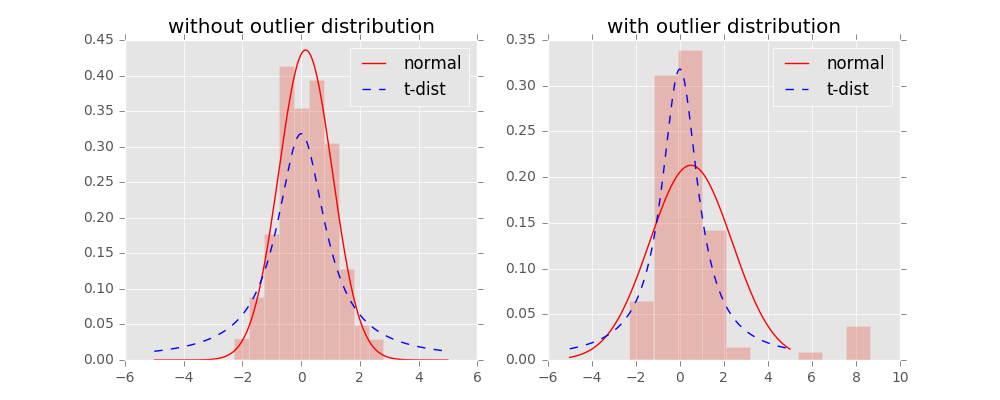
&emsp;&emsp;从图中可以看到，在没有异常点时，t分布与高斯分布的拟合结果基本一致。而在第二张图中，出现了部分异常点，由于高斯分布的尾部较低，对异常点比较敏感，为了照顾这些异常点，高斯分布的拟合结果偏离了大多数样本所在位置，方差也较大。相比之下，t分布的尾部较高，对异常点不敏感，保证了其鲁棒性，因此其拟合结果更为合理，较好的捕获了数据的整体特征。所以我们可以考虑使用t分布的长尾性来改进SNE。
&emsp;&emsp;改进的方法如下：在高维空间下我们使用高斯分布将距离转换为概率分布，在低维空间下，我们使用更加偏重长尾分布的方式来将距离转换为概率分布，使得高维度下中低等的距离在映射后能够有一个较大的距离。<br>
&emsp;&emsp;使用t分布之后的点q变化如下：

$$q_{i|j}=\frac{(1+||y_{i}-y_{j}||^{2})^{-1}}{\sum_{k\neq l}(1+||y_{i}-y_{j}||^{2})^{-1}}$$ 

&emsp;&emsp;此外，t分布时无限多个高斯分布的叠加，计算上不是指数的，会方便很多，优化的梯度如下：

$$\frac{\delta C}{\delta y_{i}} = 4\sum_{j}(p_{i|j}-q_{i|j})(y_{i}-y_{j})(1+||y_{i}-y_{j}||^{2})^{-1}$$

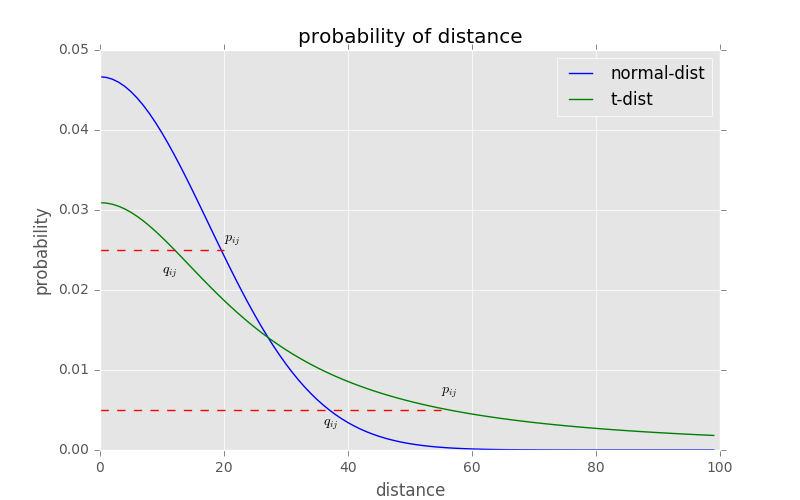
t-SNE的有效性可以从上图看到，对于高维空间中相距较近的点，为了满足$p_{i|j}=q_{i|j}$，低维空间中的距离需要稍小一些，而对于高维空间中相距较远的点，为了满足$p_{i|j}=q_{i|j}$，低维空间中的距离需要更远，这恰好满足了我们的需求，即同一簇内的点(距离较近)聚合的更紧密，不同簇之间的点(距离较远)更加疏远。

&emsp;&emsp;**总结一下，t-SNE的梯度更新有两大优势：**<br>

&emsp;&emsp;&emsp;&emsp;对于不相似的点，用一个较小的距离会产生较大的梯度来让这些点排斥开来。<br>
&emsp;&emsp;&emsp;&emsp;这种排斥又不会无限大(梯度中分母)，避免不相似的点距离太远。<br>

## 算法过程
+ Data: X = $x_{1}$,...,$x_{n}$
+ 计算cost function的参数：困惑度Perp
+ 优化参数：设置迭代次数T，学习速率$\eta$，动量$\alpha(t)$
+ 目标结果是用低维数据表示$Y^{T}=y_{1},...,y_{n}$
+ 开始优化
    * 计算在给定Perp下的条件概率$p_{j|i}$
    * 令$p_{j|i}= \frac{p_{j|i}+p_{i|j}}{2n}$
    * 用N(0,10^{-4}I)随机初始化Y
    迭代，从t=1到T，做如下操作：
        - 计算低维度下的$q_{i|j}$
        - 计算梯度
        - 更新$Y^{(t)} = Y^{(t-1)} + \eta\frac{\delta C}{\delta Y} + \alpha(t)(Y^{(t-1)}-Y^{(t-2)})$
    * 结束
+ 结束


**优化过程中可以尝试的两个trick:**<br>

&emsp;&emsp;提前压缩(early compression):开始初始化的时候，各个点要离得近一点。这样小的距离，方便各个聚类中心的移动。可以通过引入L2正则项(距离的平方和)来实现。<br>
&emsp;&emsp;提前夸大(early exaggeration)：在开始优化阶段，$p_{i|j}$乘以一个大于1的数进行扩大，来避免因为$q_{i|j}$
太小导致优化太慢的问题。比如前50次迭代，$p_{i|j}$乘以4。<br>


## t-SNE的不足
* 主要用于可视化，很难用于其他目的。比如测试集合降维，因为他没有显式的预估部分，不能在测试集合直接降维；比如降维到10维，因为t分布偏重长尾，1个自由度的t分布很难保存好局部特征，可能需要设置成更高的自由度。
* t-SNE倾向于保存局部特征，对于本征维数(intrinsic dimensionality)本身就很高的数据集，是不可能完整的映射到2-3维的空间。
* t-SNE没有唯一最优解，且没有预估部分。如果想要做预估，可以考虑降维之后，再构建一个回归方程之类的模型去做。但是要注意，t-sne中距离本身是没有意义，都是概率分布问题。
* 训练太慢。有很多基于树的算法在t-sne上做一些改进。

## SNE和PCA的对比
|降维方法|是否线性|思想|数据的解释性|
|:---:|:---:|:---:|:---:|
|PCA（主成分分析）|线性降维|通过原始变量的少数几个线性组合来解释绝大多数信息|PCA变换后会丧失数据的解释性|
|SNE（随机邻域嵌入）|非线性降维|将距离转化成概率，保证高维空间中相似的数据点在低维空间中尽量挨得近|降维后，原数据的特征值不复存在，不能根据降维结果做任何推断，本质上是一种数据探索和可视化技术|

In [44]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(1797, 2)
(1797, 2)


(<matplotlib.figure.Figure at 0x1194288d0>,
  <matplotlib.text.Text at 0x1198be050>])

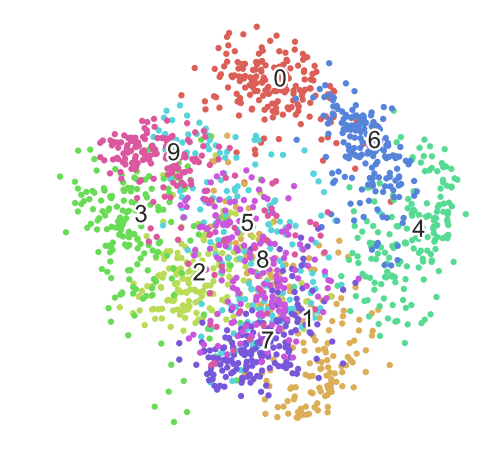

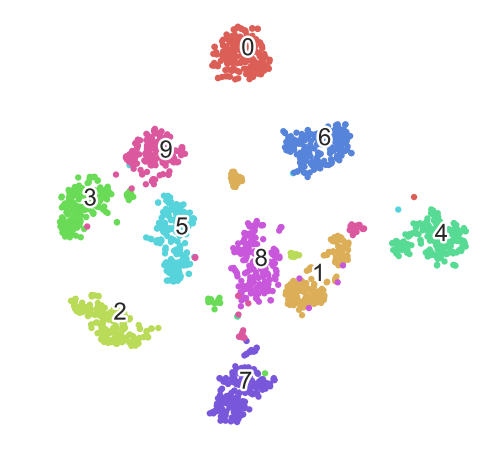

In [48]:
from sklearn import datasets
digits = datasets.load_digits()
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

tsne =TSNE(n_components=2, init='pca', random_state=0)
'''n_components维度降为2维,init设置embedding的初始化方式，可选random或者pca'''
X_tsne = tsne.fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(X)

scatter(X_pca, y)

scatter(X_tsne, y)


如上图所示，第一张图是对10个数字进行PCA降维后的结果，第二张图是使用t-SNE进行降维后的结果。

## 参考资料
1. [从SNE到t-SNE](http://www.360doc.com/content/17/0828/11/41787016_682720729.shtml)
2. [t-SNE完整笔记](http://www.datakit.cn/blog/2017/02/05/t_sne_full.html#5-代码)
3. [SNE降维与可视化](https://www.cnblogs.com/JueJi-2017/p/7487292.html)
4. [比PCA降维更高级 —— t-SNE聚类算法实现指南](https://yq.aliyun.com/articles/70733)